In [1]:
import IPython.display
import ipywidgets

import matplotlib
import matplotlib.animation
import matplotlib.cm
import matplotlib.collections
import matplotlib.colors
import matplotlib.patches
import matplotlib.pyplot as plt

import numpy as np

import scipy
import scipy.ndimage

import skimage.io

import sklearn.cluster
import sklearn.datasets
import sklearn.manifold
import sklearn.metrics
import sklearn.mixture
import sklearn.preprocessing

figure_dpi = 150
width = 1920
height = 600
fig_width, fig_height = np.array((width, height)) / figure_dpi

def subplots(width=fig_width, height=fig_height, dpi=figure_dpi, tight_layout=True, **kwargs):
    fig, axes = plt.subplots(figsize=(width, height), dpi=dpi, **kwargs)
    if tight_layout:
        fig.tight_layout()
    return fig, axes

In [2]:
# data
# not necessary in real world scenario, just for consistency
class DataWithLabels(object):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        
def make_data(*Xy):
    return DataWithLabels(Xy[0], Xy[1])
    
    
np.random.seed(0)

n_samples = 500
noisy_circles = make_data(*sklearn.datasets.make_circles(
    n_samples=n_samples,
    factor=.5,
    noise=.05))
noisy_moons   = make_data(*sklearn.datasets.make_moons(n_samples=n_samples, noise=.05))
blobs         = make_data(*sklearn.datasets.make_blobs(n_samples=n_samples, random_state=8))
no_structure  = make_data(*np.random.rand(n_samples, 2), np.zeros((n_samples,)))

# Anisotropicly distributed data
random_state = 170
X, y = sklearn.datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = make_data(*(X_aniso, y))

# blobs with varied variances
varied = make_data(*sklearn.datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[0.3, 2.2, 0.5],
                             random_state=random_state))
# print(np.min(noisy_circles[0][:, 0]), np.min(noisy_circles[0][:, 1]), np.max(noisy_circles[0][:, 0]), np.max(noisy_circles[0][:, 1]))
# print(np.min(blobs[0][:, 0]), np.min(blobs[0][:, 1]), np.max(blobs[0][:, 0]), np.max(blobs[0][:, 1]))

In [3]:
def nudge_images(X, y):
    # Having a larger dataset shows more clearly the behavior of the
    # methods, but we multiply the size of the dataset only by 2, as the
    # cost of the hierarchical clustering methods are strongly
    # super-linear in n_samples
    shift = lambda x: scipy.ndimage.shift(x.reshape((8, 8)),
                                  .3 * np.random.normal(size=2),
                                  mode='constant',
                                  ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y

In [4]:
# slow cell, I recommend to run only once
digits = sklearn.datasets.load_digits(n_class=10)
X = digits.data
y = digits.target
X, y = nudge_images(X, y)
n_samples, n_features = X.shape
X_red = sklearn.manifold.SpectralEmbedding(n_components=2).fit_transform(X)
X_imgs = X.reshape(X.shape[0], 8, 8)

In [5]:
def scatter_data(data, color='k', alpha=0.5, ax=None, disable_ticks=False, **kwargs):
    if not ax:
        fig, ax = subplots()
    scatter = ax.scatter(data[:,0], data[:,1], c=color, alpha=alpha, **kwargs)
    if disable_ticks:
        ax.set_xticks([])
        ax.set_yticks([])
    return ax, scatter

def equidistant_colors(n, shift=1/10, s=0.5, v=1.0):
    return np.array([matplotlib.colors.hsv_to_rgb(((index / n) + shift, s, v)) for index in range(n)])

def visualize_prediction(dimensionality_reduced_data, labels, ax=None, **kwargs):
    m, M = np.min(labels), np.max(labels)
    colors = equidistant_colors(M - m + 1)
    if (m < 0):
        colors[:-m] = 0
    return scatter_data(dimensionality_reduced_data, color=colors[labels - m], ax=ax, **kwargs)

def evaluate(labels_pred, labels_true=y, metric=sklearn.metrics.adjusted_rand_score):
    return metric(labels_true, labels_pred)

In [6]:
class EveryPointIsCluster(object):
    
    def fit_predict(self, X, y=None):
        return np.arange(X.shape[0])
    
class RandomAssignments(object):
    def __init__(self, n_clusters):
        super().__init__()
        self.n_clusters = n_clusters
        
    def fit_predict(self, X, y=None):
        return np.random.randint(0, self.n_clusters, size=X.shape[0])

### Theoretical Exercises
 1. Show/argue that minimizing inertia $\sum_{i=1}^K\sum_{x\in S_i} || x -\mu_i||^2$ in kmeans
   - minimizes within cluster variance, and
   - minimizes pairwise dissimilarities within cluster.
 2. Show that Mixture of Gaussians $p(x)=\sum_{i=1}^K \phi_i \mathcal{N}(x|\mu_i, \Sigma_i)$ is a probability density function
 3. Show that for a Mixture of Gaussians: $p(x) = \sum_z p(x, z)$
 4. Relate KMeans to Gaussian Mixture Models wrt to expectation minimization.

### Hands On Exercises
 1. Get familiar with sklearn clustering methods: http://scikit-learn.org/stable/modules/clustering.html
 2. Get familiar with sklearn clustering metrics: http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
 3. Cluster generated data with different clustering methods available in scikit-learn
 4. Cluster scikit-learn digits into 10 clusters
   - Try different scikit learn clustering algorithms: http://scikit-learn.org/stable/modules/clustering.html 
     - modify parameters
     - try to cluster both on original data (`X`) and dimensionality reduced data (`X_red`)
   - visualize and evaluate (see cells below)
     - try various metrics: http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
 5. Lossy compression/vector quantiziation with KMeans. Compress example image (or image of choice) with KMeans at different settings. Visualize the results and compare. What is the compression factor?

Clustering scored: 0.0


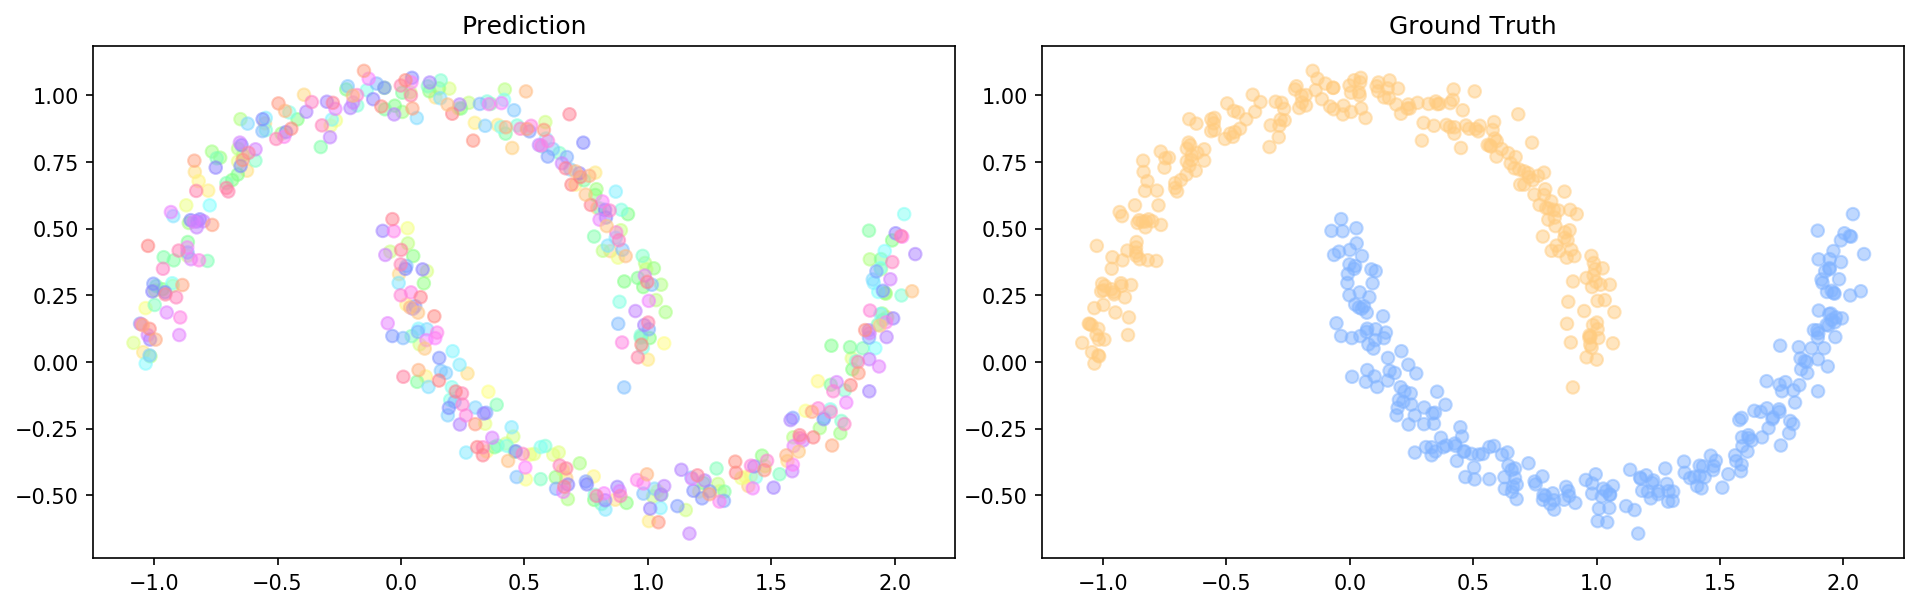

In [7]:
%matplotlib inline

# Exercise (3)

# TODO: uncomment data set to use
# data = noisy_circles
data = noisy_moons
# data = blobs
# data = no_structure
# data = aniso
# data = varied

# TODO: select model (Replace EveryPointIsCluster() with different sklearn clustering models)
model_for_generated_data = EveryPointIsCluster()

labels_for_generated_data = model_for_generated_data.fit_predict(data.X)
fig_generated, [ax1_generated, ax2_generated] = subplots(ncols=2)
visualize_prediction(data.X, labels_for_generated_data, ax=ax1_generated)
visualize_prediction(data.X, data.y, ax=ax2_generated)
ax1_generated.set_title("Prediction")
ax2_generated.set_title("Ground Truth")

# select sklearn clustering metric
metric = sklearn.metrics.adjusted_rand_score
score = evaluate(labels_pred=labels_for_generated_data, labels_true=data.y, metric=metric)
print("Clustering scored:", score)

In [8]:
# visualize feature space
dpi=100
%matplotlib inline
@ipywidgets.interact(sample=(0, X.shape[0]-1, 1))
def update(sample):
    fig_feature_space, (ax1_feature_space, ax2_feature_space) = subplots(nrows=2, width=800/dpi, height=600/dpi)
    scatter_data(X_red, ax=ax1_feature_space, alpha=0.1)
    im_feature_space = ax2_feature_space.imshow(X_imgs[sample], cmap='Greys_r')
    ax2_feature_space.set_xticks([])
    ax2_feature_space.set_yticks([])
    highlight_feature_space = matplotlib.patches.Circle(X_red[sample], color=equidistant_colors(2)[1], alpha=0.7, radius=0.03)
    ax1_feature_space.add_patch(highlight_feature_space)
    plt.show()
    print("Sample % 4d: label % 2d"%(sample, y[sample]))

interactive(children=(IntSlider(value=1796, description='sample', max=3593), Output()), _dom_classes=('widget-…

Clustering scored: 0.0010300230957378215


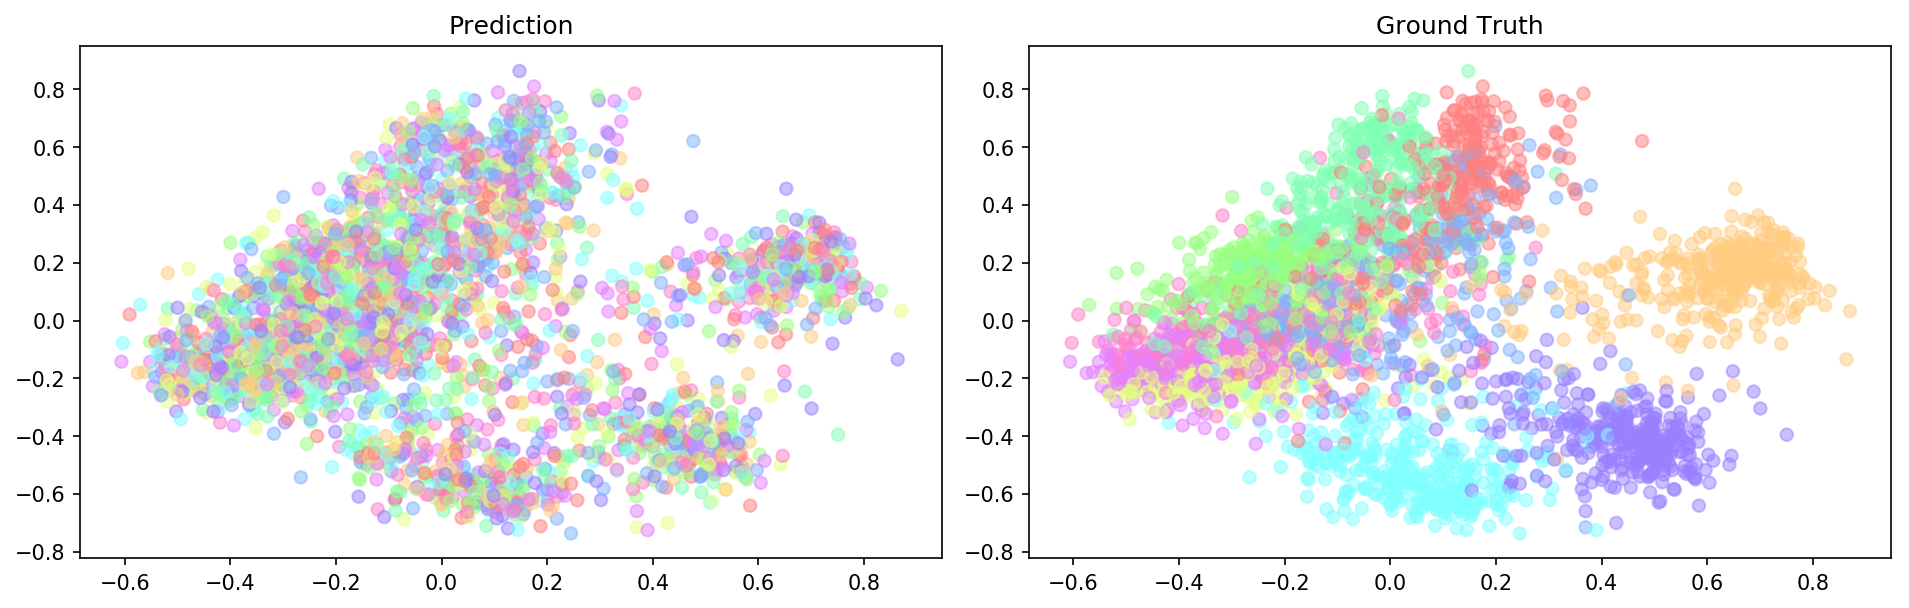

In [9]:
%matplotlib inline

# Exercise (4)

# Task: Try different clustering models on mnist data (10 clusters). 
# Replace EveryPointIsCluster model with an sklearn model and tune parameters!

# replace, e.g. with sklearn.cluster.KMeans
# models at
# http://scikit-learn.org/stable/modules/clustering.html
# play with parameters
n_digits = 10

# TODO: select model (Replace RandomAssignments() with different sklearn clustering models)
model = RandomAssignments(n_digits)

# try both X and X_red to fit model
labels = model.fit_predict(X)

# if model supports outliers, outliers (label < 0) are assigned black color
fig_digits, [ax1_digits, ax2_digits] = subplots(ncols=2)
visualize_prediction(dimensionality_reduced_data=X_red, labels=labels, ax=ax1_digits)
visualize_prediction(dimensionality_reduced_data=X_red, labels=y, ax=ax2_digits)
ax1_digits.set_title("Prediction")
ax2_digits.set_title("Ground Truth")

# select sklearn clustering metric
metric = sklearn.metrics.adjusted_rand_score
score = evaluate(labels_pred=labels, metric=metric)
print("Clustering scored:", score)

In [10]:
%matplotlib inline
# assigned label may not be the same as ground truth label!
selection = 9
matches = labels == selection
n_matches = np.sum(matches)
X_red_matches = X_red[matches]
X_imgs_matches = X_imgs[matches]
y_matches = y[matches]
colors = equidistant_colors(2)
dpi = 100

@ipywidgets.interact(sample=(0, n_matches-1, 1))
def update(sample):
    cluster_fig, (cluster_ax1, cluster_ax2) = subplots(nrows=2, width=800 / dpi, height=600 / dpi, dpi=dpi)
    scatter_data(X_red, ax=cluster_ax1, alpha=0.01)
    scatter_data(X_red_matches, ax=cluster_ax1, alpha=0.7, color=colors[0])
    cluster_im = cluster_ax2.imshow(X_imgs_matches[sample], cmap='Greys_r')
    cluster_ax2.set_xticks([])
    cluster_ax2.set_yticks([])
    cluster_highlight = matplotlib.patches.Circle(X_red_matches[sample], color=colors[1], alpha=0.7, radius=0.03)
    cluster_ax1.add_patch(cluster_highlight)
    plt.show()

interactive(children=(IntSlider(value=175, description='sample', max=351), Output()), _dom_classes=('widget-in…

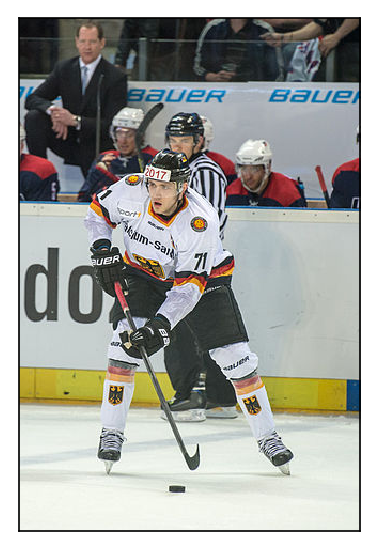

In [11]:
%matplotlib inline

# recommendation: use mini batch kmeans for speed up

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Leon_Draisaitl_Team_Deutschland_by_2eight_DSC0761.jpg/320px-Leon_Draisaitl_Team_Deutschland_by_2eight_DSC0761.jpg'
img = skimage.io.imread(url)

img_as_list_of_points = img.reshape(np.prod(img.shape[:2]), img.shape[2])

# choose number of centers. Hint: start with lower number as higher numbers might take longer to compute.
compression_levels = []

# this holds the compressed imgs. Decompress back to rgb space before appending to this
compressed_imgs = []

for compression_level in compression_levels:
    # TODO compress img and append decompressed img to compressed_imgs
    # e.g.
    # model = ...
    # model.fit(img_as_list_of_points)
    # compress img_as_list_of_points with model
    # img = decompress (to visualize lossy compression)
    # compressed_imgs.append(img)
    pass


# Exercise (5)
compression_fig, compression_axes = subplots(ncols=len(compressed_imgs) + 1)
if isinstance(compression_axes, matplotlib.axes.Axes):
    compression_axes = [compression_axes]

for ax in compression_axes:
    ax.set_xticks([])
    ax.set_yticks([])

for index, im in enumerate([img] + compressed_imgs):
    compression_axes[index].imshow(im)